## DNA Sequencing With Machine Learning

In this notebook, I will apply a classification model that can predict a gene's function based on the DNA sequence of the coding sequence alone.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
human_data = pd.read_table('human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


### We have some data for human DNA sequence coding regions and a class label.  We also have data for Chimpanzee and a more divergent species, the dog.

In [3]:
chimp_data = pd.read_table('chimp_data.txt')
dog_data = pd.read_table('dog_data.txt')
chimp_data.head()
dog_data.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


### Here are the definitions for each of the 7 classes and how many there are in the human training data.  They are gene sequence function groups.

In [4]:
from IPython.display import Image
Image("Capture1.PNG")

TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

### Treating DNA sequence as a "language", otherwise known as  k-mer counting

A challenge that remains is that none of these above methods results in vectors of uniform length, and that is a requirement for feeding data to a classification or regression algorithm. So with the above methods you have to resort to things like truncating sequences or padding with "n" or "0" to get vectors of uniform length.

DNA and protein sequences can be viewed metaphorically as the language of life. The language encodes instructions as well as function for the molecules that are found in all life forms. The sequence language analogy continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides (motifs) are words, and nucleotide bases and amino acids are the alphabet. Since the analogy seems so apt, it stands to reason that the amazing work done in the natural language processing field should also apply to the natural language of DNA and protein sequences.

The method I use here is simple and easy. I first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

Here I am using hexamer “words” but that is arbitrary and word length can be tuned to suit the particular situation. The word length and amount of overlap need to be determined empirically for any given application.

In genomics, we refer to these types of manipulations as "k-mer counting", or counting the occurances of each possible k-mer sequence. There are specialized tools for this, but the Python natural language processing tools make it supe easy.

Here is a function that can be used to convert any sequence (string) to overlapping k-mer words:

### Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. We will basically apply the k-mers to the complete sequences.

In [5]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=5):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

## Now we can convert our training data sequences into short overlapping  k-mers of legth 6.  Lets do that for each species of data we have using our getKmers function.

In [6]:
human_data['words'] = human_data.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_data.drop('sequence', axis=1)
chimp_data['words'] = chimp_data.apply(lambda x: getKmers(x['sequence']), axis=1)
chimp_data = chimp_data.drop('sequence', axis=1)
dog_data['words'] = dog_data.apply(lambda x: getKmers(x['sequence']), axis=1)
dog_data = dog_data.drop('sequence', axis=1)

### Now, our coding sequence data is changed to lowercase, split up into all possible k-mer words of length 6 and ready for the next step.  Let's take a look.

In [7]:
human_data.head()

,class,words
0,4,"[atgcc, tgccc, gcccc, cccca, cccaa, ccaac, caa..."
1,4,"[atgaa, tgaac, gaacg, aacga, acgaa, cgaaa, gaa..."
2,3,"[atgtg, tgtgt, gtgtg, tgtgg, gtggc, tggca, ggc..."
3,3,"[atgtg, tgtgt, gtgtg, tgtgg, gtggc, tggca, ggc..."
4,3,"[atgca, tgcaa, gcaac, caaca, aacag, acagc, cag..."


### Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use.  We can also make a y variable to hold the class labels.  Let's do that now.

In [8]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[:, 0].values                         

In [9]:
print(human_texts[2])

atgtg tgtgt gtgtg tgtgg gtggc tggca ggcat gcatt cattt atttg tttgg ttggg tgggc gggcg ggcgc gcgct cgctg gctgt ctgtt tgttt gtttg tttgg ttggc tggca ggcag gcagt cagtg agtga gtgat tgatg gatga atgat tgatt gattg attgc ttgcc tgcct gcctt ccttt ctttc tttct ttctg tctgt ctgtt tgttc gttca ttcag tcagt cagtg agtgt gtgtc tgtct gtctg tctga ctgag tgagt gagtg agtgc gtgct tgcta gctat ctatg tatga atgaa tgaag gaaga aagat agatt gattg attgc ttgca tgcac gcaca cacac acaca cacag acaga cagag agagg gaggt aggtc ggtcc gtcca tccag ccaga cagat agatg gatgc atgca tgcat gcatt cattc attcc ttccg tccgt ccgtt cgttt gtttt ttttg tttga ttgag tgaga gagaa agaat gaatg aatgt atgtc tgtca gtcaa tcaat caatg aatgg atgga tggat ggata gatac ataca tacac acacc cacca accaa ccaac caact aactg actgc ctgct tgctg gctgc ctgct tgctt gcttt ctttg tttgg ttgga tggat ggatt gattt atttc tttca ttcac tcacc caccg accgg ccggt cggtt ggttg gttgg ttggc tggcg ggcgg gcggt cggta ggtag gtagt tagtt agttg gttga ttgac tgacc gaccc acccg cccgc ccgct cgctg gctgt ctgtt tgtt

In [10]:
y_data

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

## We will perform the same steps for chimpanzee and dog

In [11]:
chimp_texts = list(chimp_data['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_chimp = chimp_data.iloc[:, 0].values                       # y_c for chimp

dog_texts = list(dog_data['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_dog = dog_data.iloc[:, 0].values   

## Now we will apply the BAG of WORDS using CountVectorizer using NLP

In [12]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [13]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 65447)
(1682, 65447)
(820, 65447)


### If we have a look at class balance we can see we have relatively balanced dataset.

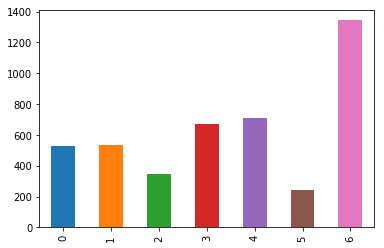

In [14]:
human_data['class'].value_counts().sort_index().plot.bar()

In [15]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_data, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [16]:
print(X_train.shape)
print(X_test.shape)

(3504, 65447)
(876, 65447)


### A multinomial naive Bayes classifier will be created.  I previously did some parameter tuning and found the ngram size of 4 (reflected in the Countvectorizer() instance) and a model alpha of 0.1 did the best.

In [17]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [18]:
y_pred = classifier.predict(X_test)

### Okay, so let's look at some model performce metrics like the confusion matrix, accuracy, precision, recall and f1 score.  We are getting really good results on our unseen data, so it looks like our model did not overfit to the training data.  In a real project I would go back and sample many more train test splits since we have a relatively small data set.

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0   1   2    3    4   5    6
Actual                                  
0          97   0   0    0    4   0    1
1           5  92   0    1    3   0    5
2           0   0  77    0    1   0    0
3           0   0   0  122    2   0    1
4           2   0   0    0  143   0    4
5           0   0   0    0    0  48    3
6           2   1   0    3    1   1  257
accuracy = 0.954 
precision = 0.955 
recall = 0.954 
f1 = 0.954
